In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import multiprocessing

from WordTool import WordTool
from Glyph import Glyph

In [4]:
class Glyph():
    def __init__(self, glyph, score):
        self.glyph = glyph
        self.dScore = [score]
        self.nbTime = 0
        self.iterationOccurence = []

    def getUncertainty(self):
        if len(self.dScore) == 1:
            return 1
        elif len(self.dScore) <= 2:
            return np.std(self.dScore)
        else:
            return np.std(self.dScore[-2:])

    def getMastery(self):
        # do a weighted average do give more importance to last values
        if len(self.dScore) > 2:
            return np.average(np.array(self.dScore[1:]), weights=[(i + 1)**2 for i in range(len(self.dScore[1:]))])
        else:
            return self.dScore[-1]

    # change that to exponential, maybe degree 2 ?
    def getProgress(self):
        if len(self.dScore) <= 1:
            return 0
        else:
            x = np.array(range(len(self.dScore)))
            z = np.polyfit(x, self.dScore, 1)
            return z[0]
        
    def isNew(self):
        if len(self.dScore) == 1:
            return True
    
        return False

In [5]:
# hyperparameters
low = 0.1

mu_motivation, sigma_motivation = 0.5, 0.1 # motivation de l'eleve au debut [0, 1]
mu_resilience, sigma_resilience = 0.05, 0.02 # resilience: a quel point le success ou l'echec affecte la motivation [-0.1, 0.1]
mu_level, sigma_level = 0.5, 0.1 # niveau de l'eleve au debut [0, 1]
mu_decreaseMotiv, sigma_decreaseMotiv = 0.02, 0.003 # a quel point la motivation decroit avec le temps [0, 0.1]
mu_deltaMotivation, sigma_deltaMotivation = 0.15, 0.005 # a quel point le success est influence par la motivation [0, 0.2]
mu_progress, sigma_progress = 0.03, 0.01 # probability of success should increase with number time we meet this letter [0, 0.1]
# progres par lettre ?

mu_pLow, sigma_pLow =  0.2, 0.1# probability of mastering letter if mastered at iteration -1 (at it 0)
mu_pHigh, sigma_pHigh = 0.8, 0.05 # probability of mastering letter if failed at iteration -1 (at it 0)

# create word tool.. containing dico
wt = WordTool()

In [6]:
class Student():
    
    def __init__(self, id_student, alpha, beta):
        self.id = id_student
        self.iteration = 1
        self.lettersUnderInvestigation = []
        self.wordsWritten = []
        self.letters = {}
        
        # poids exploration/exploitation
        self.alpha = alpha # exploration
        self.beta = beta # exploitation
        
        ### probability of transition ###
        self.pLow = np.random.normal(mu_pLow, sigma_pLow, 1)[0] # probability of mastering letter if failed at it -1
        self.pHigh = np.random.normal(mu_pHigh, sigma_pHigh, 1)[0] # probability of mastering letter if mastered at it -1
        if self.pLow > 1 or self.pLow < 0:
            self.pLow = float(int(self.pLow))
        if self.pHigh > 1 or self.pHigh < 0:
            self.pHigh = float(int(self.pHigh))
        
        ### resilience ###
        self.resilience = np.random.normal(mu_resilience, sigma_resilience, 1)[0]
        
        ### how much success is influenciated by motivation ###
        self.deltaMotivation = np.random.normal(mu_deltaMotivation, sigma_deltaMotivation, 1)[0]
        
        ### decrease motivation - how much motivation decrease with time ###
        self.deltaDecreaseMotivation = np.random.normal(mu_decreaseMotiv, sigma_decreaseMotiv, 1)[0]
        
        ### score letters ###
        for glyph in "abcdefghijklmnopqrstuvwxyz":
            scoreLet = np.random.normal(mu_level, sigma_level, 1)[0]
            # make sure the score of the letter is btw [0.0, 1.0]
            while (scoreLet < 0.) or (scoreLet > 1.):
                scoreLet = np.random.normal(mu_level, sigma_level, 1)[0]
            # create object glyph
            self.letters[glyph] = Glyph(glyph, scoreLet)

        ### motivation ###
        self.motivation = -1
        while self.motivation < 0.:
            self.motivation = np.random.normal(mu_motivation, sigma_motivation, 1)[0]
            
        ### how success if influence by number of letters occurence
        self.progressPotential = np.random.normal(mu_motivation, sigma_motivation, 1)[0]
            
    def getMeanLevelLetters(self):
        return np.mean([self.letters[let].getMastery() for let in self.letters])
    
    def chooseNextWord(self):
        cost = {}
        
        # update mastery, pertinence and uncertainty of words from dico
        wt.updateWords(self.letters)

        # for each word of dictionnary
        for word in wt.words:
            if word not in self.wordsWritten:
                # compute cost of word
                temp = self.alpha*(abs(wt.words[word]["mastery"] - 1. + self.motivation)*(1-math.exp(-0.5*self.iteration)))**2. + self.beta*abs(low+(1-low)*math.exp(-0.35*self.iteration)-wt.words[word]["uncertainty"])**2.
                cost[word] = temp

        # choose word with least cost
        min_val = min(cost.values())
        newWord = [k for k, v in cost.items() if v == min_val][0]
        self.wordsWritten.append(newWord)

        # update letters under investigation
        self.lettersUnderInvestigation = [l for l in newWord.lower()]
        for l in newWord.lower():
            self.letters[l].iterationOccurence.append(self.iteration)
            self.letters[l].nbTime += 1
            
        # update iteration number
        self.iteration += 1
            
    def updateParams(self):
        
        # proba of success increases with motivation
        # linear model btw -delta for mot = 0 to delta for mot = 1
        increaseMotivation = -self.deltaMotivation + 2*self.deltaMotivation*self.motivation
        
        nbSuccess = 0
        for let in self.lettersUnderInvestigation:
            
            # probability of success should increase with number nb of times we meet this letter
            nbOccurence = self.letters[let].nbTime
            increaseProgress = 2*self.progressPotential/(1 + math.exp(-nbOccurence*0.05)) - self.progressPotential
            
            letterMastery = self.letters[let].getMastery()
            pHigh = self.pHigh + increaseMotivation + increaseProgress
            if pHigh > 1 or pHigh < 0:
                pHigh = float(int(pHigh))

            pLow = self.pLow + increaseMotivation + increaseProgress
            if pLow > 1 or pLow < 0:
                pLow = float(int(pLow))

            # new proba of success
            letterMastery = 5.*(letterMastery - 0.5)
            pSuccess = (pHigh - pLow)/(1 + math.exp(-letterMastery)) + pLow
            newScore = np.random.choice([1., 0.], p=[pSuccess, 1. - pSuccess])
                    
                    
            if newScore == 1.:
                nbSuccess += 1
            
            self.letters[let].dScore.append(newScore)
            
            
            
        
        ############ update motivation ############
        # percentage success
        percSuccess = nbSuccess/float(len(self.lettersUnderInvestigation))
        
        # change motivation in function of success/failure
        deltaMotiv = 2*self.resilience*(1./(1 + math.exp(-(percSuccess-0.5)*10)) - 0.5)
        
        # doit aussi dependre de la motivation elle meme, si tres motivé, difficile de le motiver encore plus
        # si pas motive du tout, facile de le remotiver
        if deltaMotiv < 0:
            deltaMotiv *= self.motivation
        else:
            deltaMotiv *= 1 - self.motivation
        self.motivation += deltaMotiv
        
        # motivation decreases over time
        decreaseMotiv = -2*self.deltaDecreaseMotivation/(1 + math.exp(-self.iteration*0.05)) + self.deltaDecreaseMotivation
        self.motivation += decreaseMotiv
        
        # should be btw 0 and 1
        if self.motivation > 1. or self.motivation < 0:
            self.motivation = float(int(self.motivation))
            
        #print("perc success", percSuccess)   
        #print("delta motiv due to success", deltaMotiv)
        #print("delta motiv due to iteration", decreaseMotiv)
        #print(self.motivation)

            
    def printWord(self):
        word = ""
        for let in students[7].lettersUnderInvestigation:
            word += let
        print(word)
        

In [10]:
def computeResults(alpha, beta, results):
    students = [Student(i, alpha, beta) for i in range(50)]
    
    scores = []
    motivations = []
    stdScores = []
    stdMotivation = []
    for it in range(10):

        for student in students:
            student.chooseNextWord()
            student.updateParams()


        scores.append(np.mean([s.getMeanLevelLetters() for s in students]))
        stdScores.append(np.std([s.getMeanLevelLetters() for s in students]))
        motivations.append(np.mean([s.motivation for s in students]))
        stdMotivation.append(np.std([s.motivation for s in students]))
    
    print("alpha:", alpha, "beta:", beta, "scores", scores[-1])
    results[alpha] = {"scores": scores, "motivations": motivations, "stdScores": stdScores, "stdMotivation": stdMotivation}
   

In [11]:
manager = multiprocessing.Manager()
results = manager.dict()

for alpha in np.arange(0.0, 1.0, 0.3):
    
    beta = 1 - alpha
    print("process launched for (alpha, beta)", alpha, beta)
    process = multiprocessing.Process(target=computeResults, args=(alpha, beta, results))
    process.start()
    #process.join()

process launched for (alpha, beta) 0.0 1.0
process launched for (alpha, beta) 0.3 0.7
process launched for (alpha, beta) 0.6 0.4
process launched for (alpha, beta) 0.9 0.1
alpha: 0.3 beta: 0.7 scores 0.52180170971
alpha: 0.6 beta: 0.4 scores 0.532446400002
alpha: 0.9 beta: 0.1 scores 0.523829691257
alpha: 0.0 beta: 1.0 scores 0.521986611219


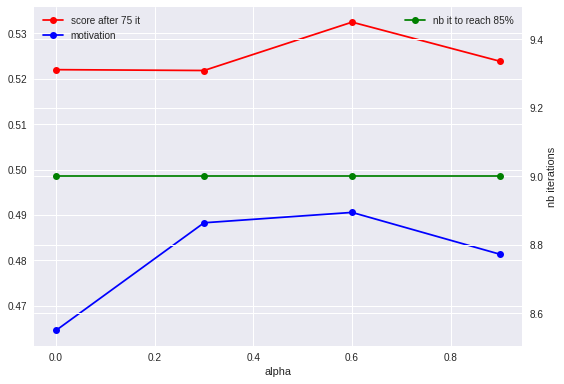

In [12]:
# fetch result
if type(results) != dict:
    results = results._getvalue()

# compute min number of iteration to reach 75% of mastered letters


xSorted = sorted([i for i in results])
score = [results[i]["scores"][-1] for i in xSorted]
motivation = [results[i]["motivations"][-1] for i in xSorted]

nbIt = []
for j, alpha in enumerate(xSorted):
    for i, val in enumerate(results[alpha]["scores"]):
        if val > 0.85:
            nbIt.append(i)
            break
            
    if len(nbIt) <= j:
        nbIt.append(i)



fig, ax1 = plt.subplots()
line1, = ax1.plot(xSorted, score, "or-", label = "score after 75 it")
line2, = ax1.plot(xSorted, motivation, "ob-", label = "motivation")
ax1.set_xlabel('alpha')

ax2 = ax1.twinx()
line3, = ax2.plot(xSorted, nbIt, 'og-', label = "nb it to reach 85%")
ax2.set_ylabel('nb iterations')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)

fig.tight_layout()
plt.savefig("/home/asselbor/Desktop/simu.svg")
plt.show()

In [14]:
score

[0.83731180569118113,
 0.89507020233101175,
 0.8957633714734321,
 0.91183337802684605,
 0.92227775697811254,
 0.91619430097155286,
 0.92171581733320651,
 0.91881347379247391,
 0.92513171221132429,
 0.92130619814240478]

# check distributions of our students

/home/asselbor/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/asselbor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


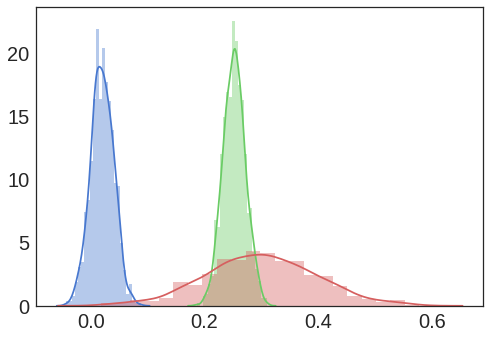

In [75]:
dist_resilience = [student.resilience for student in students]
dist_mainLevel = [student.getMeanLevelLetters() for student in students]
dist_motivation = [student.motivation for student in students]

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(dist_resilience, color="b")
sns.distplot(dist_mainLevel, color="g")
sns.distplot(dist_motivation, color="r")

plt.tick_params(labelsize=20)
plt.legend(fontsize=30, loc=0)
#plt.xlim(-1,1)
plt.show()

# check distributions of ps

/home/asselbor/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/asselbor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


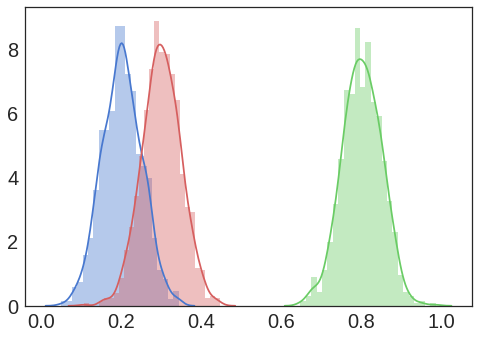

In [76]:
dist_resilience = [student.p1 for student in students]
dist_mainLevel = [student.p2 for student in students]
dist_motivation = [student.p3 for student in students]

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(dist_resilience, color="b")
sns.distplot(dist_mainLevel, color="g")
sns.distplot(dist_motivation, color="r")

plt.tick_params(labelsize=20)
plt.legend(fontsize=30, loc=0)
#plt.xlim(-1,1)
plt.show()

# curve for increase of success with motivation

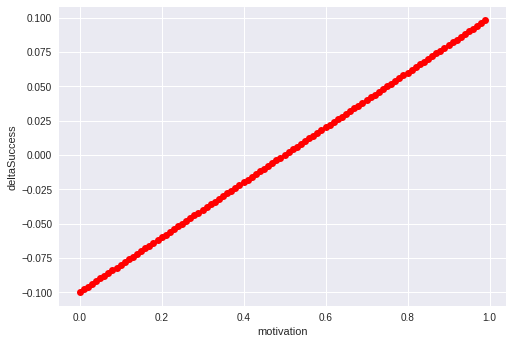

In [6]:
deltaMotivation = 0.1 # how success is affected by motivation

x = np.arange(0.0, 1.0, 0.01)
y = [-deltaMotivation + 2*deltaMotivation*i for i in x]
plt.plot(x, y, "or-")
plt.xlabel("motivation")
plt.ylabel("deltaSuccess")
plt.savefig("/home/asselbor/Desktop/c.svg")
plt.show()

# curve for increase of motivation with success

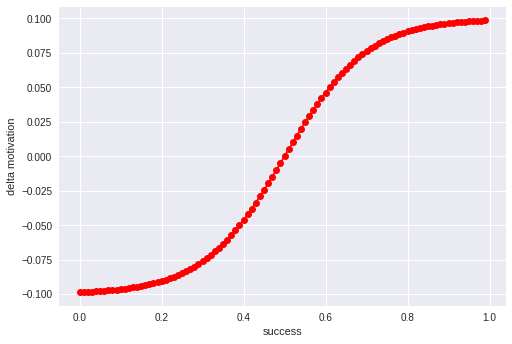

In [7]:
deltaDecrease = 0.1
x = np.arange(0.0, 1.0, 0.01)
y = [ 2*deltaDecrease*(1./(1 + math.exp(-(i-0.5)*10)) - 0.5) for i in x]
plt.plot(x, y, "or-")
plt.xlabel("success")
plt.ylabel("delta motivation")
plt.savefig("/home/asselbor/Desktop/d.svg")
plt.show()

# curve for decrease of motivation with iteration

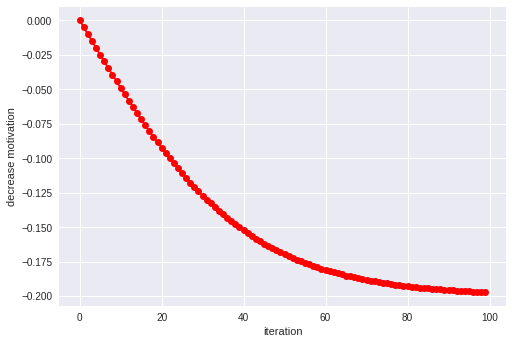

In [8]:
deltaDecrease = 0.2
x = np.arange(0.0, 100.0, 1)
y = [ -2*deltaDecrease/(1 + math.exp(-i*0.05)) + deltaDecrease for i in x]
plt.plot(x, y, "or-")
plt.xlabel("iteration")
plt.ylabel("decrease motivation")
plt.savefig("/home/asselbor/Desktop/e.svg")
plt.show()

# curve for progress vs nb of letter's occurence

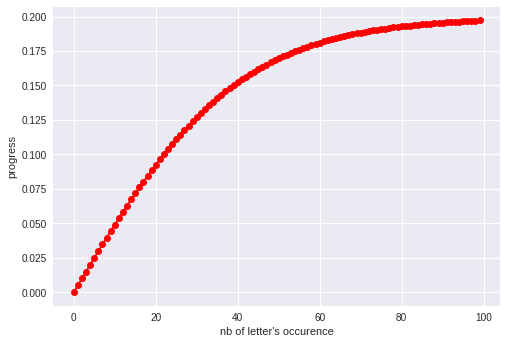

In [5]:
potentialProgress = 0.2

x = np.arange(0.0, 100.0, 1)
y = [ 2*potentialProgress/(1 + math.exp(-i*0.05)) - potentialProgress for i in x]

plt.plot(x, y, "or-")
plt.savefig("/home/asselbor/Desktop/b.svg")
plt.xlabel("nb of letter's occurence")
plt.ylabel("progress")
plt.show()

# Probability of success of letter in function of letter mastery

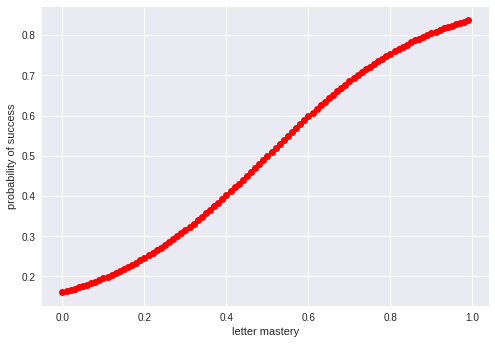

In [3]:
pHigh = 0.9
pLow = 0.1


def f(x):
    x = 5.*(x - 0.5)
    return (pHigh - pLow)/(1 + math.exp(-x)) + pLow

x = np.arange(0., 1.0, 0.01)
y = [f(i) for i in x]

plt.plot(x, y, "or-")
plt.savefig("/home/asselbor/Desktop/a.svg")
plt.xlabel("letter mastery")
plt.ylabel("probability of success")
plt.show()

In [ ]:
                
                # previsouly mastered
                if self.letters[let].dScore[-1] == 1:
                    pSuccess = self.p2 + increaseMotivation + increaseProgress
                    #print("p nastered", pSuccess)
                    if pSuccess > 1 or pSuccess < 0:
                        pSuccess = float(int(pSuccess))
                    newScore = np.random.choice([1., 0.], p=[pSuccess, 1. - pSuccess])
                    

                # previsouly failed    
                else:
                    pSuccess = self.p3 + increaseMotivation + increaseProgress
                    #print("p failed", pSuccess)
                    
                    if pSuccess > 1 or pSuccess < 0:
                        pSuccess = float(int(pSuccess))
                    newScore = np.random.choice([1., 0.], p=[pSuccess, 1. - pSuccess])
                    